# Week 8

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [2]:
# Read the csv file with the rapper names in the west and east coast
EastCoastRappers = pd.read_csv("../files/EastCoastRappers.csv")
WestCoastRappers = pd.read_csv("../files/WestCoastRappers.csv")
BothCoastRappers = pd.read_csv("../files/BothCoastRappers.csv")

def build_rappers_network():

    G = nx.DiGraph()
    
    # Add nodes to the graph
    for index, row in EastCoastRappers.iterrows():
        G.add_node(row['WikipediaPageName'], region='EastCoast')

    for index, row in WestCoastRappers.iterrows():
        G.add_node(row['WikipediaPageName'], region='WestCoast')

    for index, row in BothCoastRappers.iterrows():
        G.add_node(row['WikipediaPageName'], region='BothCoast')

    # Setup wikipedia requests
    WIKI_REQUEST_URL = "https://en.wikipedia.org/w/api.php?"
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'links',
        'pllimit': 'max',
        'titles': ''
    }

    # Add edges to the graph 
    # It should have an edge between two rappers if their wikipedia pages link to each other
    for index, row in EastCoastRappers.iterrows():
        params['titles'] = row['WikipediaPageName']
        request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
        for link in request:
            if (link['title'] in G.nodes()):
                G.add_edge(row['WikipediaPageName'], link['title'])

    for index, row in WestCoastRappers.iterrows():
        params['titles'] = row['WikipediaPageName']
        request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
        for link in request:
            if (link['title'] in G.nodes()):
                G.add_edge(row['WikipediaPageName'], link['title'])

    for index, row in BothCoastRappers.iterrows():
        params['titles'] = row['WikipediaPageName']
        request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
        for link in request:
            if (link['title'] in G.nodes()):
                G.add_edge(row['WikipediaPageName'], link['title'])
    
    return G

## Exercise 1: Sentiment distribution. 



> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.

> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

In [3]:
## We have a dicitonnary of words and their happiness score on the path ../data/labMIT-1.0.txt
## Word is on the first column, happiness score is on the third column

word_happiness_dict = {}
with open('../files/labMIT-1.0.txt', 'r') as f:
    for line in f:
        if line.startswith('word'):
            continue
        word, score = line.split('\t')[0], float(line.split('\t')[2])
        word_happiness_dict[word] = score

def get_happiness_score(words):
    """
    This function takes a list of lowercase words and returns the average happiness score of the words in the list.
    """
    happiness_score = 0
    for word in words:
        if word in word_happiness_dict:
            happiness_score += word_happiness_dict[word]
    return happiness_score / len(words)

> * Iterate over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.

In [4]:
G = build_rappers_network()

In [5]:
## For all nodes in the graph, compute the average happiness score of the words in the node's wikipedia page
## The pages are stored in folders ../files/eastcoasttexts/ and ../files/westcoasttexts/ and then by names

scores = []
names = []

for node in G.nodes():
    ## Get the region of the node
    region = G.nodes[node]['region']
    if region == "BothCoast":
        region = "EastCoast"
    ## Get the text file
    name = node.replace(' ', '_')
    with open(f'../files/{region.lower()}texts/{name}.txt', 'r') as f:
        text = f.read()
        ## Remove punctuation
        text = text.replace('.', '').replace(',', '').replace('?', '').replace('!', '').replace(';', '').replace(':', '')
        ## Lowercase the text
        text = text.lower()
        ## Convert the text to a list of words
        words = text.split()
        ## Compute the average happiness score of the words in the list
        if len(words) == 0:
            score = 0
        else:
            score = get_happiness_score(words)
        names.append(name)
        scores.append(score)

> * Remember histograms? Create a histogram of all character's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2).

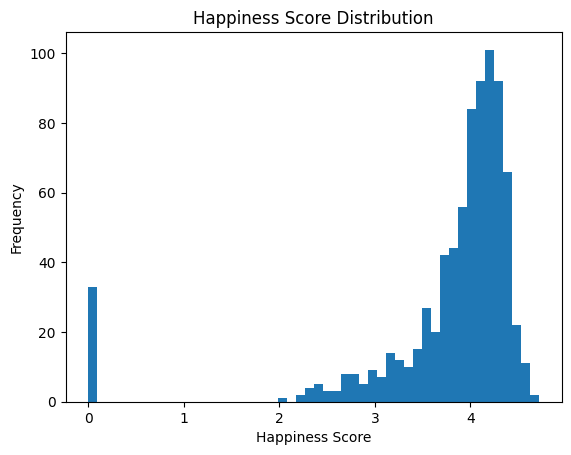

In [6]:
## Create histogram of all character's associated happiness scores

plt.hist(scores, bins=50)
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.title('Happiness Score Distribution')
plt.show()

> * Who are the 10 rappers with happiest and saddest pages?

In [9]:
happy_rappers = []
unhappy_rappers = []

both = list(zip(names, scores))
## Sort the list by the happiness score
both.sort(key=lambda x: x[1])

## Remove the rappers with a score of 0
both = [rapper for rapper in both if rapper[1] != 0]

## Get the 10 most happy rappers
for i in range(10):
    happy_rappers.append(both.pop()[0])

## Get the 10 most unhappy rappers
for i in range(10):
    unhappy_rappers.append(both.pop(0)[0])

## Print the 10 most happy rappers
print("The 10 most happy rappers are:")
for rapper in happy_rappers:
    print(rapper)

## Print the 10 most unhappy rappers
print("\nThe 10 most unhappy rappers are:")
for rapper in unhappy_rappers:
    print(rapper)

The 10 most happy rappers are:
Dom_Kennedy
Tim'm_T._West
GaTa
Dave_Free
Charles_Hamilton_(rapper)
DJ_Charlie_Chase
Lloyd_Banks
Trip_Lee
Young_Music_DYMG
Young_M.A

The 10 most unhappy rappers are:
Neo_da_Matrix
Cardiak
Sha_Money_XL
B-Legit
Arkatech_Beatz
Willie_B_(producer)
Crystal_Caines
Buckwild_(music_producer)
Droop-E
Focus...


<!---
> * Now we average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected characters. 
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by skimming the wikipedia pages?
--->

**Note**: Calculating sentiment takes a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops